In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for EDA plots
import seaborn as sns # for EDA plots
from scipy import stats # for Shapiro-Wilks test, ttest_ind
from sklearn.model_selection import train_test_split # for splitting dataframes into train & test samples

In [28]:
# Read in the 2 DFs from CSV file
df_clean = pd.read_csv('data/df_clean.csv')
df_impute = pd.read_csv('data/df_impute.csv')

# Summary of Hypothesis Tests We Will Run:

t-tests (binary categorical values):

1) Are average X different between "Has metabolic syndrome" and "Does not have metabolic syndrome"?
2) Are average X different between Male/Female?

One-way ANOVA (multi-category values):

3) Are average X different between difference Races?
4) Are average X different between Marital Statuses?  - MAY NOT DO (This is not that interesting/important)

... where X = BMI, WaistCirc, Albuminuria, UrAlbCr, UricAcid, BloodGlucose, HDL, Triglycerides.

In [29]:
# Remind of the columns names, again?
df_impute.columns

Index(['Unnamed: 0', 'seqn', 'Age', 'Sex', 'Marital', 'Income', 'Race',
       'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides', 'MetabolicSyndrome'],
      dtype='object')

In [30]:
# What are the unique categorical variables for Sex, Marital, Race, MetabolicSyndrome?
print (f"\nCategories for column: Sex:\n{df_impute['Sex'].unique()}")
print (f"\nCategories for column: Race:\n{df_impute['Race'].unique()}")
print (f"\nCategories for column: Marital:\n{df_impute['Marital'].unique()}")
print (f"\nCategories for column: MetabolicSyndrome:\n{df_impute['MetabolicSyndrome'].unique()}")


Categories for column: Sex:
['Male' 'Female']

Categories for column: Race:
['White' 'Asian' 'Black' 'MexAmerican' 'Hispanic' 'Other']

Categories for column: Marital:
['Single' 'Married' 'Widowed' 'Divorced' 'Separated']

Categories for column: MetabolicSyndrome:
[0 1]


# Hypothesis Tests for "Has MetabolicSyndrome" vs. "Doesn't Have MetabolicSyndrome"

2 steps:
1. Levene's test for equal variance, which informs the equal_var parameter for the stats.ttest_ind()
2. t-test via stats.ttest_ind()

In [90]:
# Define a list with the dimensions we want to examine in each Hypothesis Test
dimensions = ['WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']

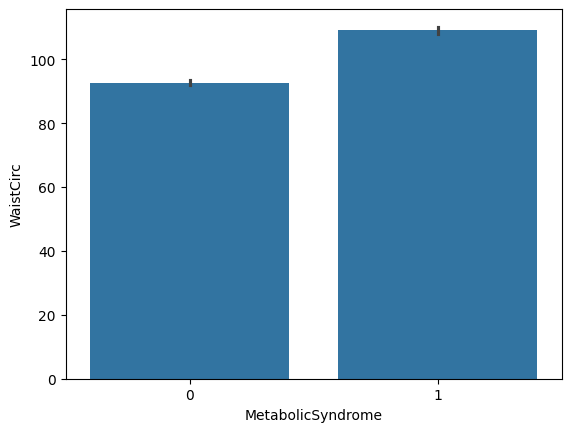

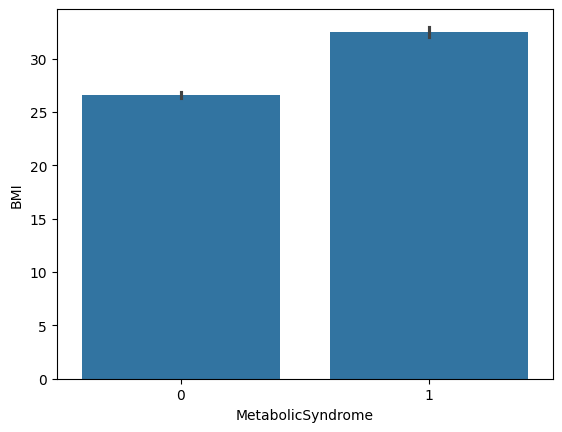

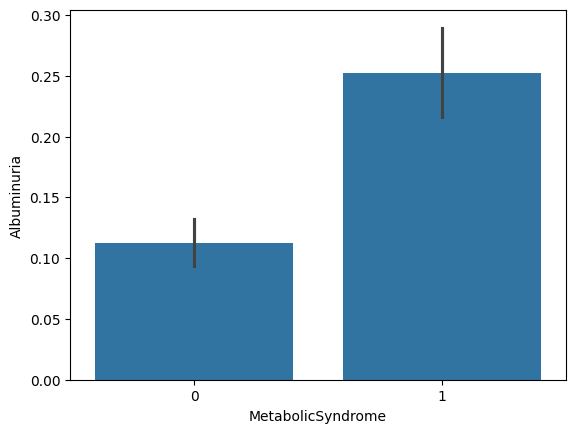

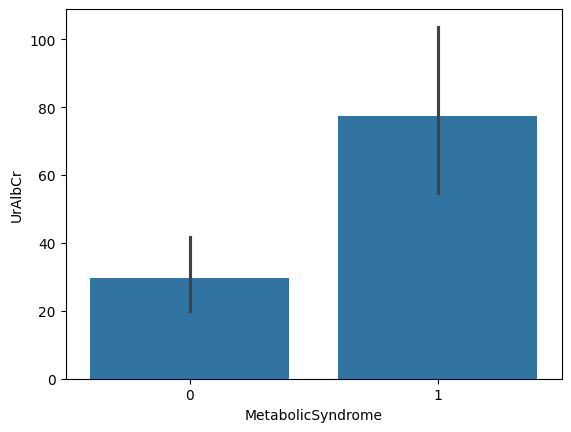

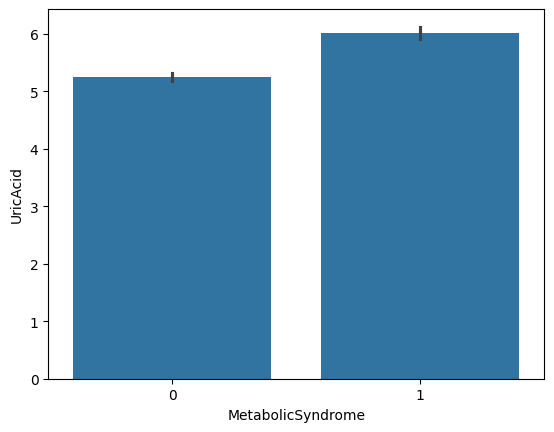

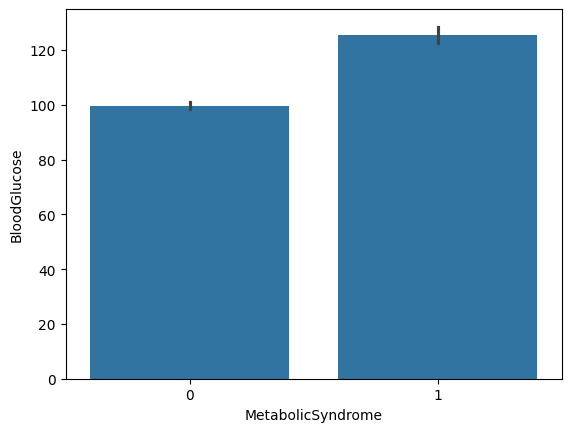

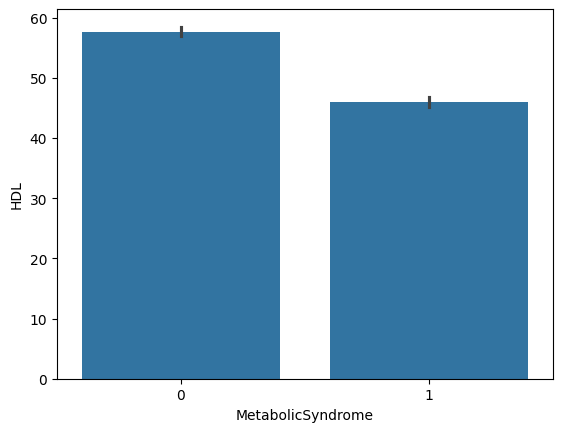

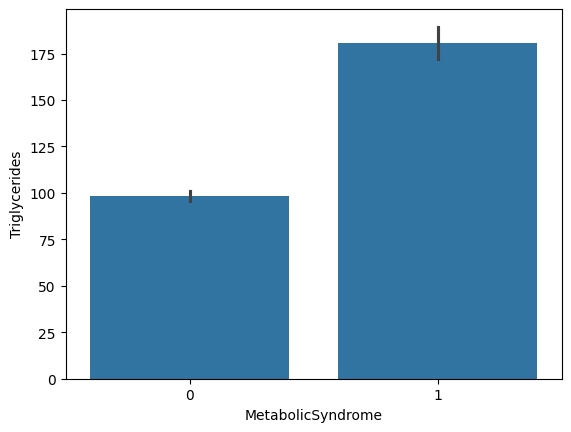

In [91]:
# Show barplot of Dimension Means on 'Metabolic Syndrome' categories:
for dimension in dimensions:
    sns.barplot(data=df_impute, x='MetabolicSyndrome', y=dimension)
    plt.show()

In [76]:
# First Use Levene's test to verify equal variance between 2 groups on dimensions:
# 'WaistCirc', 'BMI','Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'

# Define the masks
has_ms_mask = df_impute['MetabolicSyndrome'] == 1
no_ms_mask = df_impute['MetabolicSyndrome'] == 0

# Store the Levenes test results
levenes_results = []

# Store the mean for each dimension in each group
means = []

for dimension in dimensions:
    # Get the Series for Dimension in each Group
    dimension_has_ms = df_impute[has_ms_mask][dimension]
    dimension_no_ms  = df_impute[no_ms_mask][dimension]

    # Calculate the mean for each Dimension/Group
    means.append(dict({'dimension_name':dimension, 'has_ms':dimension_has_ms.mean(), 'no_ms':dimension_no_ms.mean()}))

    # Calculate and store Levene stats
    stat, p = stats.levene(dimension_has_ms, dimension_no_ms)
    levenes_results.append(dict({'dimension_name' : dimension, 'stat' : stat, 'p': p}))
    print (f"Levene test result for {dimension}: p = {p}, Result: Variances are {'**NOT** ' if p < 0.05 else ''}equal")

Levene test result for WaistCirc: p = 0.17439731450012333, Result: Variances are equal
Levene test result for BMI: p = 3.744839622941711e-05, Result: Variances are **NOT** equal
Levene test result for Albuminuria: p = 4.017997154140853e-13, Result: Variances are **NOT** equal
Levene test result for UrAlbCr: p = 0.00011067393676236355, Result: Variances are **NOT** equal
Levene test result for UricAcid: p = 0.0022105965941049094, Result: Variances are **NOT** equal
Levene test result for BloodGlucose: p = 1.668406034475705e-23, Result: Variances are **NOT** equal
Levene test result for HDL: p = 1.2286233173573101e-08, Result: Variances are **NOT** equal
Levene test result for Triglycerides: p = 2.658370873768701e-45, Result: Variances are **NOT** equal


#### Levene's test when comparing dimensions split by 'MetabolicSyndrome' (Has It vs. Does not Have It) indicates the following:

Variances are equal for the 2 groups (has_ms, no_ms) for these following dimensions, and we can use standard t-test:
1. WaistCirc

Variances are NOT equal for the 2 groups (has_ms, no_ms) for these following dimensions, and we need to use Welch's t-test (pass 'False' for equal_var in stats.ttest):
1. BMI
2. Albuminuria
3. UrAlbCr
4. UricAcid
5. BloodGlucose
6. HDL
7. Triglycerides

In [60]:
# Do t-tests for all dimensions!

t_results = []

for dict_entry in levenes_results:
    dimension = dict_entry['dimension_name']
    dimension_p = dict_entry['p']
    equal_var_param = False # Default (most of our dimensions are not equal variance)
    if dimension_p > 0.05:
        # Set 'equal_var_param' set to 'True' (meaning, 2 datasets ARE equal variance)
        #print (f"Note: Equal variances for dimension {dimension}")  # Check and confirm!
        equal_var_param = True

    # Run the t-test and store the results
    stat, p = stats.ttest_ind(df_impute[has_ms_mask][dimension], df_impute[no_ms_mask][dimension], equal_var=equal_var_param)
    t_results.append(dict({'dimension_name' : dimension, 'equal_var_param' : equal_var_param, 'stat' : stat, 'p' : p}))


In [62]:
# Gut-check that t_results is what we want; we will print out something more readable in a below cell
t_results

[{'dimension_name': 'WaistCirc',
  'equal_var_param': True,
  'stat': 26.165407054357438,
  'p': 1.5462850516600822e-131},
 {'dimension_name': 'BMI',
  'equal_var_param': False,
  'stat': 20.881735567073623,
  'p': 5.7439237164190525e-84},
 {'dimension_name': 'Albuminuria',
  'equal_var_param': False,
  'stat': 6.523071363860894,
  'p': 1.0323227968063208e-10},
 {'dimension_name': 'UrAlbCr',
  'equal_var_param': False,
  'stat': 3.381374389078004,
  'p': 0.0007485165882493893},
 {'dimension_name': 'UricAcid',
  'equal_var_param': False,
  'stat': 11.853609110639535,
  'p': 6.035533456367002e-31},
 {'dimension_name': 'BloodGlucose',
  'equal_var_param': False,
  'stat': 15.147307212572214,
  'p': 9.117590017521449e-47},
 {'dimension_name': 'HDL',
  'equal_var_param': False,
  'stat': -19.91855435350617,
  'p': 3.2667959101286097e-80},
 {'dimension_name': 'Triglycerides',
  'equal_var_param': False,
  'stat': 18.310620932503344,
  'p': 6.414711048677813e-64}]

In [77]:
# Print out the means of each Dimension:

for entry in means:
    print (f"Dimension: {entry['dimension_name']}:  Means [has_ms, no_ms]: [{entry['has_ms']}, {entry['no_ms']}]")


Dimension: WaistCirc:  Means [has_ms, no_ms]: [109.05749999999999, 92.64360587002096]
Dimension: BMI:  Means [has_ms, no_ms]: [32.547236842105264, 26.6135569531796]
Dimension: Albuminuria:  Means [has_ms, no_ms]: [0.25263157894736843, 0.11250873515024458]
Dimension: UrAlbCr:  Means [has_ms, no_ms]: [77.4975, 29.656079664570235]
Dimension: UricAcid:  Means [has_ms, no_ms]: [6.014868421052632, 5.242627533193571]
Dimension: BloodGlucose:  Means [has_ms, no_ms]: [125.47631578947369, 99.50803633822501]
Dimension: HDL:  Means [has_ms, no_ms]: [45.94210526315789, 57.6932215234102]
Dimension: Triglycerides:  Means [has_ms, no_ms]: [180.78157894736842, 98.40041928721175]


In [78]:
# Print out the results of the t-tests for 'MetabolicSyndrome' groups [0,1]

print (f"t-test results for dimensions grouped by has metabolic syndrome vs. does not have metabolic syndrome:")

significantly_different_list = ''
not_significantly_different_list = ''

for result in t_results:
    if result['p'] < 0.05:
        significantly_different_list += result['dimension_name'] + ', '
    else:
        not_significantly_different_list += result['dimension_name'] + ', '

# Get rid of last ','
significantly_different_list = significantly_different_list[:-2]
not_significantly_different_list = not_significantly_different_list[:-2]

print (f"\nSignificantly Different Means:\n\t{significantly_different_list}")
print (f"\nNOT Significantly Different Means:\n\t{not_significantly_different_list}")

t-test results for dimensions grouped by has metabolic syndrome vs. does not have metabolic syndrome:

Significantly Different Means:
	WaistCirc, BMI, UricAcid, BloodGlucose, HDL, Triglycerides

NOT Significantly Different Means:
	Albuminuria, UrAlbCr


### Results for Group Means for "Has Metabolic Syndrome" vs. "Does Not Have Metabolic Syndrome" Dimensions:

For all Dimensions, the **means are statistically different** for those who "have metabolic syndrome" vs. those who "do not have metabolic syndrome".
    
Dimensions are:
* WaistCirc
* BMI
* Albuminuria
* UrAlbCr
* UricAcid
* BloodGlucose
* HDL
* Triglycerides

# Hypothesis Tests for Male vs. Female

2 steps:
1. Levene's test for equal variance, which informs the equal_var parameter for the stats.ttest_ind()
2. t-test via stats.ttest_ind()

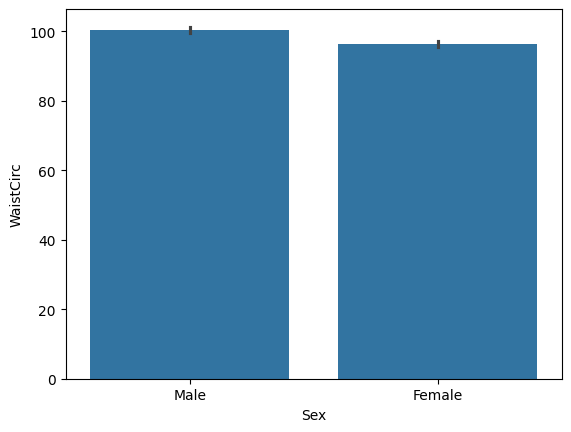

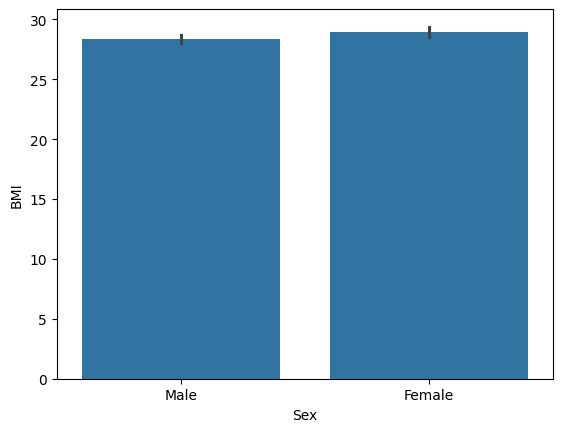

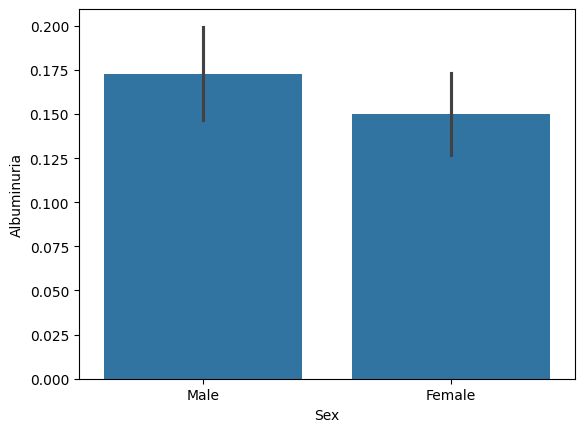

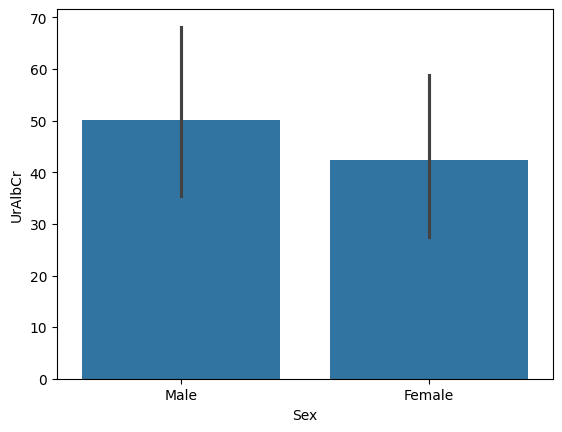

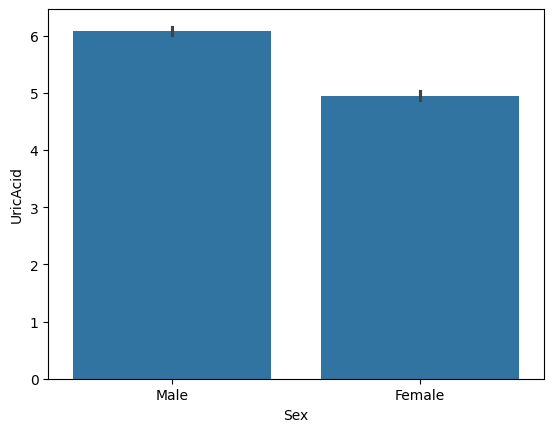

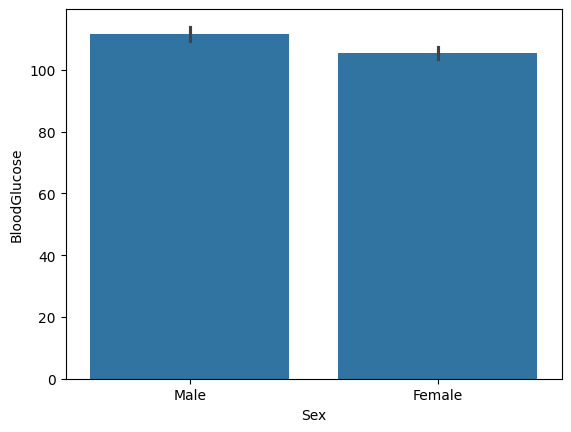

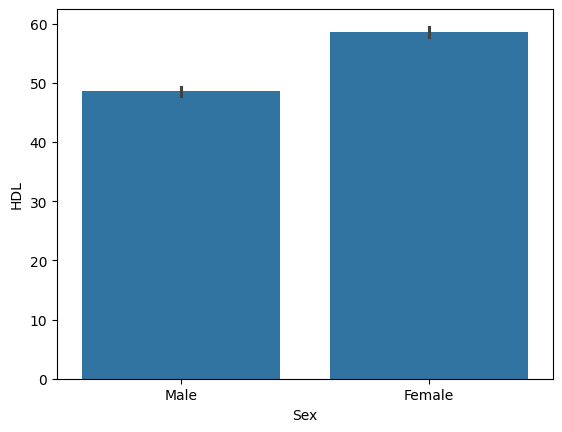

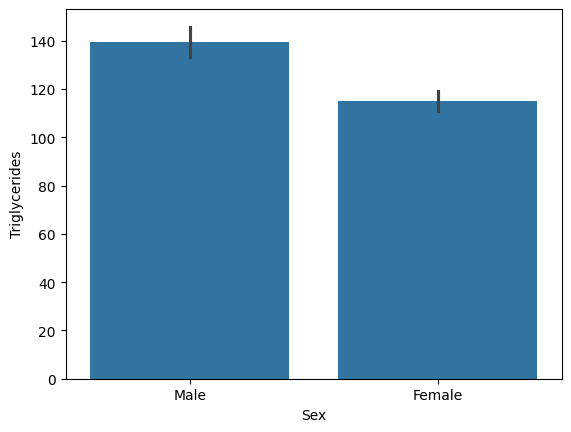

In [93]:
# Show barplot of Dimension Means on 'Sex' categories:
for dimension in dimensions:
    sns.barplot(data=df_impute, x='Sex', y=dimension)
    plt.show()

In [92]:
# First Use Levene's test to verify equal variance between 2 groups on dimensions:
# 'WaistCirc', 'BMI','Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'

# Define the masks
male_mask = df_impute['Sex'] == 'Male'
female_mask = df_impute['Sex'] == 'Female'

# Store the Levenes test results
levenes_results = []

# Store the mean for each dimension in each group
means = []

for dimension in dimensions:
    # Get the Series for Dimension in each Group
    dimension_male = df_impute[male_mask][dimension]
    dimension_female  = df_impute[female_mask][dimension]

    # Calculate the mean for each Dimension/Group
    means.append(dict({'dimension_name':dimension, 'male':dimension_male.mean(), 'female':dimension_female.mean()}))

    # Calculate and store Levene stats
    stat, p = stats.levene(dimension_male, dimension_female)
    levenes_results.append(dict({'dimension_name' : dimension, 'stat' : stat, 'p': p}))
    print (f"Levene test result for {dimension}: p = {p}, Result: Variances are {'**NOT** ' if p < 0.05 else ''}equal")

Levene test result for WaistCirc: p = 0.04287396722188298, Result: Variances are **NOT** equal
Levene test result for BMI: p = 1.609008523380027e-10, Result: Variances are **NOT** equal
Levene test result for Albuminuria: p = 0.22386664790950342, Result: Variances are equal
Levene test result for UrAlbCr: p = 0.4273973525034417, Result: Variances are equal
Levene test result for UricAcid: p = 0.2538844477285095, Result: Variances are equal
Levene test result for BloodGlucose: p = 0.20513798064969188, Result: Variances are equal
Levene test result for HDL: p = 3.909074307832056e-07, Result: Variances are **NOT** equal
Levene test result for Triglycerides: p = 3.982262659993102e-07, Result: Variances are **NOT** equal


#### Levene's test when comparing dimensions split by 'Sex' (Male vs. Female) indicates the following:

Variances are equal for the 2 groups (has_ms, no_ms) for these following dimensions, and we can use standard t-test:
1. Albuminuria
2. UrAlbCr
3. UricAcid
4. BloodGlucose

Variances are NOT equal for the 2 groups (has_ms, no_ms) for these following dimensions, and we need to use Welch's t-test (pass 'False' for equal_var in stats.ttest):
1. BMI
2. HDL
3. Triglycerides

In [80]:
# Do t-tests for all dimensions!

t_results = []

for dict_entry in levenes_results:
    dimension = dict_entry['dimension_name']
    dimension_p = dict_entry['p']
    equal_var_param = False # Default (most of our dimensions are not equal variance)
    if dimension_p > 0.05:
        # Set 'equal_var_param' set to 'True' (meaning, 2 datasets ARE equal variance)
        #print (f"Note: Equal variances for dimension {dimension}")  # Check and confirm!
        equal_var_param = True

    # Run the t-test and store the results
    stat, p = stats.ttest_ind(df_impute[male_mask][dimension], df_impute[female_mask][dimension], equal_var=equal_var_param)
    t_results.append(dict({'dimension_name' : dimension, 'equal_var_param' : equal_var_param, 'stat' : stat, 'p' : p}))

In [81]:
# Print out the means of each Dimension:

for entry in means:
    print (f"Dimension: {entry['dimension_name']}:  Means [male, female]: [{entry['male']}, {entry['female']}]")

Dimension: WaistCirc:  Means [male, female]: [100.39754174397032, 96.3415543575921]
Dimension: BMI:  Means [male, female]: [28.356447124304268, 28.97722371967655]
Dimension: Albuminuria:  Means [male, female]: [0.1725417439703154, 0.1500449236298293]
Dimension: UrAlbCr:  Means [male, female]: [50.157949907235626, 42.46691823899372]
Dimension: UricAcid:  Means [male, female]: [6.085807050092765, 4.953279424977538]
Dimension: BloodGlucose:  Means [male, female]: [111.66790352504638, 105.46271338724169]
Dimension: HDL:  Means [male, female]: [48.529684601113175, 58.544474393531]
Dimension: Triglycerides:  Means [male, female]: [139.3126159554731, 115.02785265049415]


In [82]:
# Print out the results of the t-tests for 'Sex' groups ['Male', 'Female]

print (f"t-test results for dimensions grouped by has metabolic syndrome vs. does not have metabolic syndrome:")

significantly_different_list = ''
not_significantly_different_list = ''

for result in t_results:
    if result['p'] < 0.05:
        significantly_different_list += result['dimension_name'] + ', '
    else:
        not_significantly_different_list += result['dimension_name'] + ', '

# Get rid of last ','
significantly_different_list = significantly_different_list[:-2]
not_significantly_different_list = not_significantly_different_list[:-2]

print (f"\nSignificantly Different Means:\n\t{significantly_different_list}")
print (f"\nNOT Significantly Different Means:\n\t{not_significantly_different_list}")


t-test results for dimensions grouped by has metabolic syndrome vs. does not have metabolic syndrome:

Significantly Different Means:
	WaistCirc, BMI, UricAcid, BloodGlucose, HDL, Triglycerides

NOT Significantly Different Means:
	Albuminuria, UrAlbCr


### Results for Group Means for Male vs. Female Dimensions:

For the following Dimensions, the **means are statistically different** for Males vs. Females:
    
Dimensions are:
* WaistCirc
* BMI
* UricAcid
* BloodGlucose
* HDL
* Triglycerides

For the following Dimensions, there is **no statistical difference between means** for Males vs. Females:
* Albuminuria
* UrAlbCr

# Hypothesis Tests for Race: ['White' 'Asian' 'Black' 'MexAmerican' 'Hispanic' 'Other']

1 step:
One-way ANOVA (stats.f_oneway()).

NOTE:  One-way ANOVA assumes that:
1. the data is normal
2. the variances of the groups are approximately equal

According to https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php:
a) one-way ANOVA "tolerates violations to its normality assumption rather well"

According to https://www.quality-control-plan.com/StatGuide/oneway_anova_ass_viol.htm:
b) if variances aren't equal, effect mitigated when sample sizes are equal


There is a greater likelihood of Type I errors if ANOVA is used with data that don't have equal variances and sample sizes aren't equal (which they do not, from data below).

However, due to the following considerations, I will accept the potential for increased Type I errors in this situation:
1) This is an analysis only, where:
- We will be building a logistic regression model wherein the OR and other statistical measures of validity will be examined
- The analysis here is to add to EDA and inform hypothesis generation primarily, and is not of its own primary importance

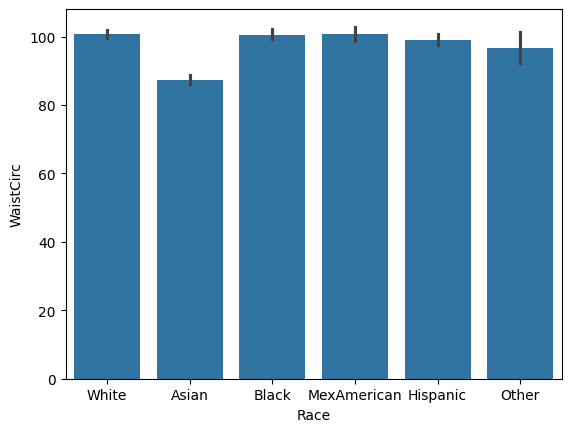

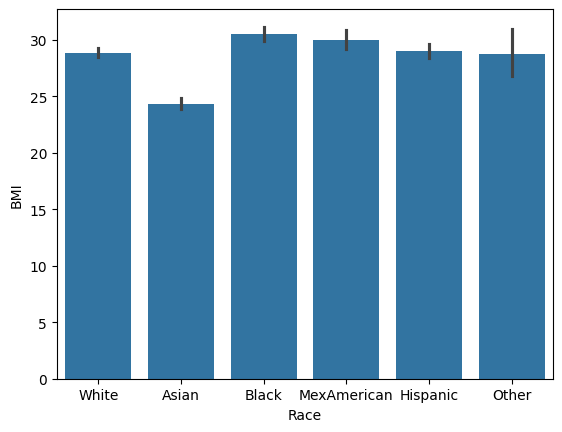

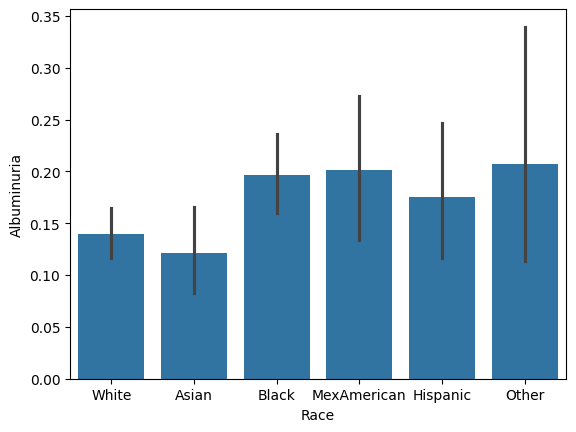

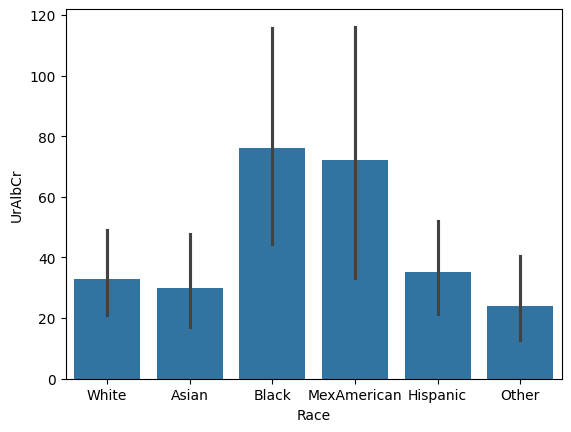

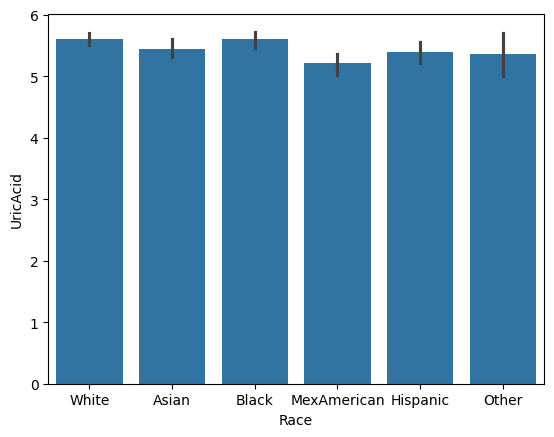

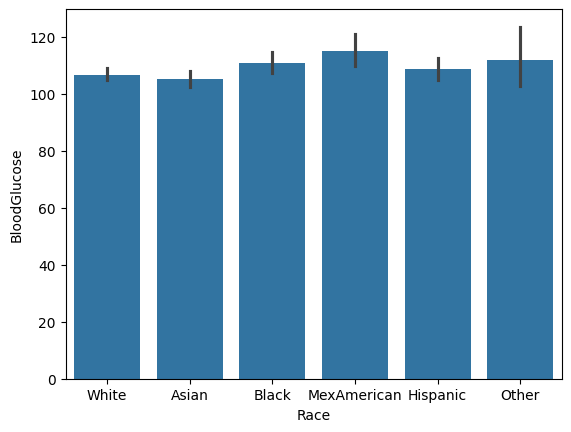

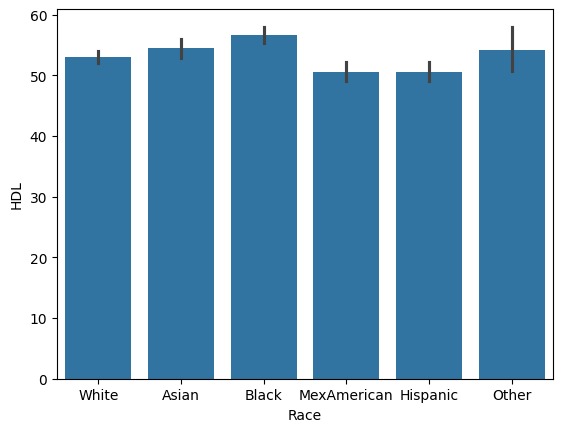

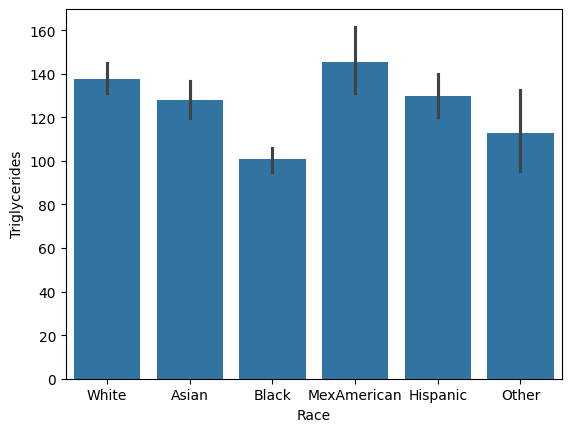

In [94]:
# Show barplot of Dimension Means on 'Marital' categories:
for dimension in dimensions:
    sns.barplot(data=df_impute, x='Race', y=dimension)
    plt.show()

In [128]:
# Gut-check barplot means value shown in first graph
df_impute[df_impute['Race']=='Asian']['BMI'].mean()

24.3542899408284

In [122]:
# Define masks for each Race
# categories = ['White', 'Asian', 'Black', 'MexAmerican', 'Hispanic', 'Other']

white_mask = df_impute['Race']=='White'
asian_mask = df_impute['Race']=='Asian'
black_mask = df_impute['Race']=='Black'
mexamerican_mask = df_impute['Race']=='MexAmerican'
hispanic_mask = df_impute['Race']=='Hispanic'
other_mask = df_impute['Race']=='Other'

# Define ANOVA results
anova_results = []

# Define means storage
means = []

# Define sample size storage
sample_sizes = []

# Define Series for each Dimension
for dimension in dimensions:
    # Get the Series for Dimension in each Group
    dimension_white  = df_impute[white_mask][dimension]
    dimension_asian  = df_impute[asian_mask][dimension]
    dimension_black  = df_impute[black_mask][dimension]
    dimension_mexamerican  = df_impute[mexamerican_mask][dimension]
    dimension_hispanic  = df_impute[hispanic_mask][dimension]
    dimension_other  = df_impute[other_mask][dimension]

    # Calculate the mean for each Dimension/Group
    means.append(dict({'dimension_name':dimension, 'white':dimension_white.mean(), 'asian':dimension_asian.mean(), 'black':dimension_black.mean(), 'mexamerican':dimension_mexamerican.mean(), 'hispanic':dimension_hispanic.mean(), 'other':dimension_other.mean()}))

    # Calculate sample size for each Dimension/Group
    sample_sizes.append(dict({'dimension_name':dimension, 'white':dimension_white.count(), 'asian':dimension_asian.count(), 'black':dimension_black.count(), 'mexamerican':dimension_mexamerican.count(), 'hispanic':dimension_hispanic.count(), 'other':dimension_other.count()}))

    # Calculate and store ANOVA stats
    stat, p = stats.f_oneway(dimension_white, dimension_asian, dimension_black, dimension_mexamerican, dimension_hispanic, dimension_other)
    anova_results.append(dict({'dimension_name' : dimension, 'stat' : stat, 'p': p}))
    print (f"ANOVA test result for {dimension}: p = {p}, Result: {'At least one of the' if p < 0.05 else 'NO'} means are different")

ANOVA test result for WaistCirc: p = 1.2664899308101302e-41, Result: At least one of the means are different
ANOVA test result for BMI: p = 1.6087757628112e-41, Result: At least one of the means are different
ANOVA test result for Albuminuria: p = 0.04978846166002772, Result: At least one of the means are different
ANOVA test result for UrAlbCr: p = 0.03037828402588226, Result: At least one of the means are different
ANOVA test result for UricAcid: p = 0.0036045035249721133, Result: At least one of the means are different
ANOVA test result for BloodGlucose: p = 0.0053576190316102406, Result: At least one of the means are different
ANOVA test result for HDL: p = 1.5909934535479864e-07, Result: At least one of the means are different
ANOVA test result for Triglycerides: p = 2.998200847895345e-13, Result: At least one of the means are different


In [123]:
# Print out the means of each Dimension:

for entry in means:
    print (f"Dimension: {entry['dimension_name']}:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [{entry['white']}, {entry['asian']}, {entry['black']}, {entry['mexamerican']}, {entry['hispanic']}, {entry['other']}]")

Dimension: WaistCirc:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [100.66622093023257, 87.35650887573965, 100.555905511811, 100.80143540669856, 99.0365470852018, 96.64528301886791]
Dimension: BMI:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [28.856744186046512, 24.3542899408284, 30.510925196850398, 29.998564593301435, 29.048878923766814, 28.758490566037732]
Dimension: Albuminuria:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [0.13953488372093023, 0.12130177514792899, 0.1968503937007874, 0.20095693779904306, 0.17488789237668162, 0.20754716981132076]
Dimension: UrAlbCr:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [32.81323255813953, 30.045059171597632, 76.25673228346456, 72.29334928229666, 35.196143497757845, 23.86547169811321]
Dimension: UricAcid:  Means [White, Asian, Black, Mexamerican, Hispanic, Other]: [5.601162790697674, 5.4402366863905325, 5.59763779527559, 5.205263157894738, 5.390134529147982, 5.362264150943396]
Dimen

In [124]:
# Print out the sample sizes of each Dimension:

for entry in sample_sizes:
    print (f"Dimension: {entry['dimension_name']}:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [{entry['white']}, {entry['asian']}, {entry['black']}, {entry['mexamerican']}, {entry['hispanic']}, {entry['other']}]")

Dimension: WaistCirc:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: BMI:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: Albuminuria:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: UrAlbCr:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: UricAcid:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: BloodGlucose:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: HDL:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]
Dimension: Triglycerides:  Sample Sizes [White, Asian, Black, Mexamerican, Hispanic, Other]: [860, 338, 508, 209, 223, 53]


### Results for Group Means for difference Races:

For all Dimensions, **at least one of the means are statistically different** amongst different Races: White, Asian, Black, Mexamerican, Hispanic, Other.
    
Dimensions are:
* WaistCirc
* BMI
* Albuminuria
* UrAlbCr
* UricAcid
* BloodGlucose
* HDL
* Triglycerides